Generating samples

In [2]:
import numpy as np

def auto_regressive_func(x1, x2, x3):
    u = np.random.uniform(0, 0.1)
    return 0.6 * x1 - 0.5 * x2 - 0.2 * x3 + u

def generate_data(n):
    x1 = np.random.uniform(0, 0.1)
    x2 = np.random.uniform(0, 0.1)
    x3 = np.random.uniform(0, 0.1)

    data = []
    data.append(x1)
    data.append(x2)
    data.append(x3)

    for i in range(n):
        x1, x2, x3 = auto_regressive_func(x1, x2, x3), x1, x2
        data.append(x1)

    return np.array(data)

Splitting Data

In [3]:
#y3, ....., y2004
#x1, x2, ...., x2002
data = generate_data(4003)
train_data = data[:2003]
test_data = data[2003:]

x_train = []
x_test = []
y_train = []
y_test = []

for i in range(2000):
    x_train.append(train_data[i:i + 3])
    x_test.append(test_data[i:i + 3])
    y_train.append(train_data[i + 3])
    y_test.append(test_data[i + 3])

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train = x_train.reshape((2000, 3, 1))
x_test = x_test.reshape((2000, 3, 1))
y_train = y_train.reshape((2000, 1))
y_test = y_test.reshape((2000, 1))

RNN Class

In [4]:
import torch
import torch.nn as nn

# recnn = nn.RNN(1, 10, 1)
# inp = torch.randn(3, 100, 1)
# h = torch.randn(1, 100, 10)
# outp, hn = recnn(inp, h)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h)
        out = self.linear(out[:, -1, :])
        
        return out

Train function

In [5]:
#train the model
def train_model(model, criterion, optimizer, num_epochs):

    input_data = torch.from_numpy(x_train.astype(np.float32))
    label_data = torch.from_numpy(y_train.astype(np.float32))

    loss_list = []
    epoch_list = []
    
    for epoch in range(num_epochs): 
        sum = 0
        for i in range(100):
            optimizer.zero_grad()

            inputs = input_data[i * 20:(i+1) * 20]
            labels = label_data[i * 20:(i+1) * 20]

            outputs = model(inputs)
            #print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            sum += loss.item()

            # if (epoch + 1) % 10 == 0:
            #     print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch + 1, num_epochs, loss.item()))

            loss.backward()
            optimizer.step()
        
        loss_list.append(sum / 20)
        epoch_list.append(epoch + 1)

    return loss_list, epoch_list

Test function

In [6]:
#test the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def test_model(model, criterion):

    input_data = torch.from_numpy(x_test.astype(np.float32))
    label_data = torch.from_numpy(y_test.astype(np.float32))

    outputs = model(input_data)
    loss = criterion(outputs, label_data)
    print('Test Loss: {:.6f}'.format(loss.item()))

    outputs = outputs.detach().numpy()
    label_data = label_data.detach().numpy()

    print('Mean Squared Error:', mean_squared_error(label_data, outputs))
    print('Mean Absolute Error:', mean_absolute_error(label_data, outputs))
    print('R2 Score:', r2_score(label_data, outputs))

Num_layers: 1


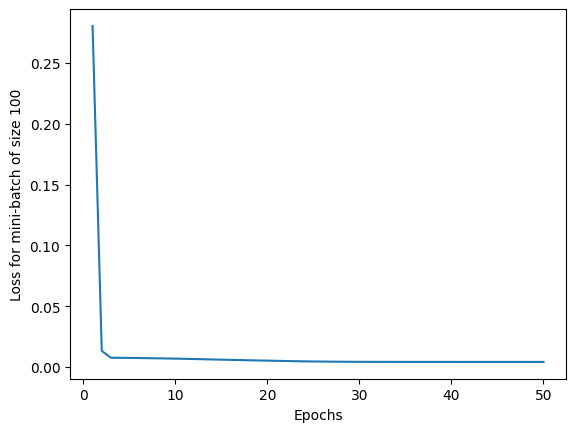

Test Loss: 0.000829
Mean Squared Error: 0.0008291727
Mean Absolute Error: 0.024851864
R2 Score: 0.5515045424354073

Num_layers: 2


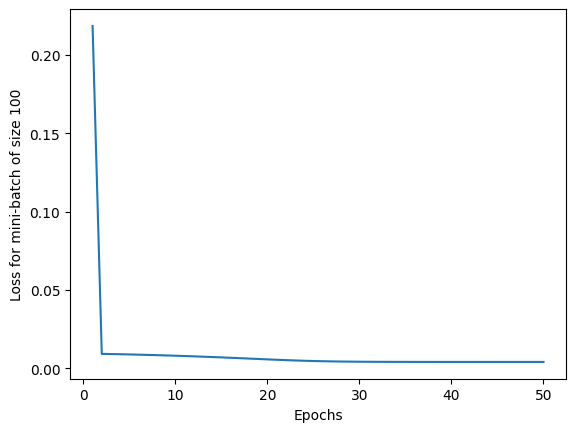

Test Loss: 0.000827
Mean Squared Error: 0.0008273511
Mean Absolute Error: 0.02483246
R2 Score: 0.55248980648037

Num_layers: 3


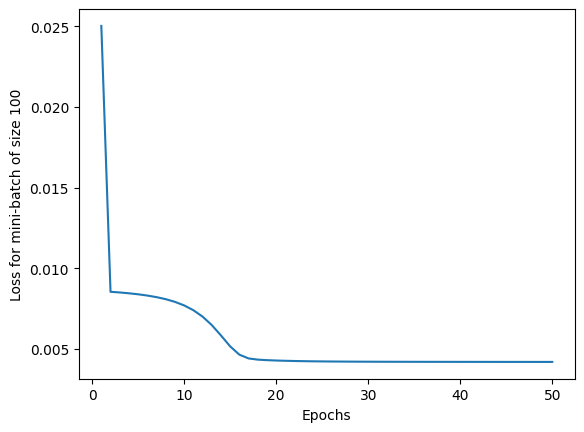

Test Loss: 0.000844
Mean Squared Error: 0.0008441019
Mean Absolute Error: 0.025036957
R2 Score: 0.5434293654057731



In [7]:
import matplotlib.pyplot as plt
#pass input to RNN
input_size = 1
hidden_size = 3
output_size = 1

for i in range(1, 4):
    print('Num_layers:', i)
    model = RNN(input_size, hidden_size, output_size, num_layers=i)
    #loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    #train the model
    loss_list, epoch_list =  train_model(model, criterion, optimizer, num_epochs=50)
    plt.plot(epoch_list, loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Loss for mini-batch of size 100')
    plt.show()

    #test the model
    test_model(model, criterion)
    print()

Architecture used:
- Input size: 1
- Hidden size: 3
- Output size: 1
- No. of layers: 1, 2, 3
- Loss: MSE
- Optimizer: Adam
- Learning rate: 0.001
- Epochs: 50
- Batch_size: 20
- Time steps: 3

Results:

* No. of layers:-
- 1: R2 score = 0.5515045424354073
- 2: R2 score = 0.55248980648037
- 3: R2 score = 0.5434293654057731

From this we can observe that, R2 score doesn't vary much with no of layers